In [1]:
# Initialisation model
import sys
import os
import torch
from optimizer import Optimizer
from config import Config
import glob
import tqdm
sys.path.insert(0,'/content/NextFace') # Verify your path

# Load configuration file
config = Config()
config.fillFromDicFile('./optimConfig.ini')
config.device = 'cuda' 
config.path = './baselMorphableModel/' 

# Directory path containing all images

outputDir = './output/debug/'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)  # Create the output directory if it doesn't exist
    
torch.cuda.set_device(0)

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!
loading optim config from:  ./optimConfig.ini


Loading Basel Face Model 2017 from ./baselMorphableModel//morphableModel-2017.pickle...
loading mesh normals...
loading uv parametrization...
loading landmarks association file...
creating sampler...


/home/beltegeuse/project/NextFace/.venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3516.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading image from path: input/detailled_faces_unsplash/bikerman_256.jpg
detecting landmarks using: fan


/home/beltegeuse/project/NextFace/landmarksfan.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(landmarks, device = self.device)
init camera pose...
1/3 => Optimizing head pose and expressions using landmarks...
100%|██████████| 2000/2000 [00:11<00:00, 169.24it/s]


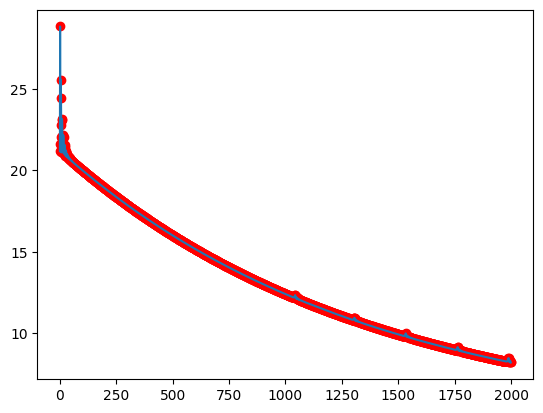

In [2]:
# Create the optimizer and input image
imagePath = "input/detailled_faces_unsplash/bikerman_256.jpg"
optimizer = Optimizer(outputDir, config)

# Choose Mitsuba and set image
optimizer.renderer = "mitsuba"
optimizer.setImage(imagePath, False) # sharedIdentity

# Run the first optimisation
optimizer.runStep1()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


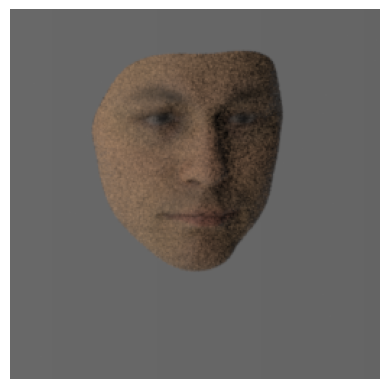

In [3]:
def renderMitsuba(spp=None):
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    
    # Uses the default albedo, specular and roughness from the morphomable model
    vDiffTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    vSpecTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    vRoughTextures = optimizer.pipeline.vRoughness
    
    # Render the image (possible to change the number of spp)
    if spp != None:
        tmpSpp = optimizer.pipeline.renderer.samples
        optimizer.pipeline.renderer.samples = spp
    out = optimizer.pipeline.renderMitsuba(None, vDiffTextures, vSpecTextures, vRoughTextures)
    if spp != None:
        optimizer.pipeline.renderer.samples = tmpSpp
    
    return out

def show(img):
    import matplotlib.pyplot as plt
    plt.axis("off")
    plt.imshow(img ** (1.0 / 2.2))
    
img = renderMitsuba()
show(img.cpu().detach()[0])

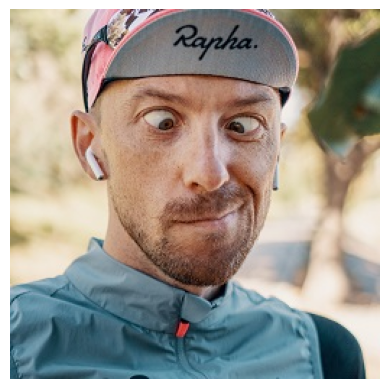

In [4]:
# Now try to compute the variance from the process
inputTensor = torch.pow(optimizer.inputImage.tensor, optimizer.inputImage.gamma)
show(inputTensor.cpu()[0])

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


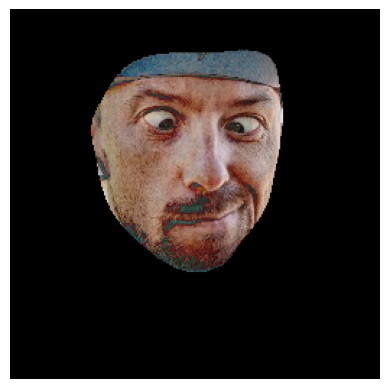

In [5]:
# Learn the lighting and Albedo
parameters_opt = torch.optim.Adam([
    {'params': optimizer.pipeline.vShCoeffs, 'lr': 0.005},
    {'params': optimizer.pipeline.vAlbedoCoeff, 'lr': 0.007}
])

losses = []
for iter in tqdm.tqdm(range(100)):
    parameters_opt.zero_grad() 
    
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)
    
    # Mitsuba
    rgba_img = optimizer.pipeline.renderMitsuba(cameraVerts, diffuseTextures, specularTextures) #mitsuba
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)
    
    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])
    
    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()
    
    # Advance optimizer
    parameters_opt.step()

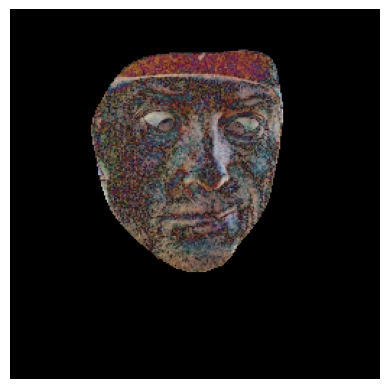

In [6]:
# Last difference
show(diff.cpu().detach()[0])

[49.126625061035156, 47.91293716430664, 46.821834564208984, 45.69268035888672, 44.74219512939453, 43.669063568115234, 42.72062683105469, 41.81618118286133, 40.84305953979492, 40.0073356628418, 39.045326232910156, 38.0146484375, 37.23393249511719, 36.454444885253906, 35.753108978271484, 34.8840217590332, 34.26099395751953, 33.569610595703125, 32.81685256958008, 32.23728942871094, 31.67997932434082, 31.233427047729492, 30.771093368530273, 30.316572189331055, 29.945390701293945, 29.487451553344727, 29.216569900512695, 29.001604080200195, 28.828920364379883, 28.670259475708008, 28.43448829650879, 28.1326847076416, 28.23396873474121, 28.205997467041016, 28.105632781982422, 28.01146697998047, 28.0373592376709, 27.8867130279541, 27.898128509521484, 27.66365623474121, 27.882564544677734, 27.557424545288086, 27.508195877075195, 27.57612419128418, 27.65822410583496, 27.48426628112793, 27.389177322387695, 27.20068359375, 27.075260162353516, 26.926998138427734, 27.04302406311035, 27.00753784179687

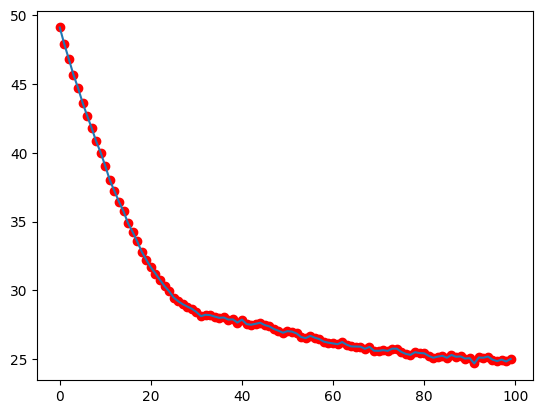

In [7]:
# Show loss 
print(losses)
optimizer.plotLoss(losses, 1, optimizer.outputDir + 'checkpoints/stage2_loss.png')

In [8]:
import matplotlib.pyplot as plt
print("Exp:")
print(optimizer.pipeline.vExpCoeff.cpu().detach())
print("Shape:")
print(optimizer.pipeline.vShapeCoeff.cpu().detach())

Exp:
tensor([[-30.9474,  33.9681,  32.0999, -33.5445,  39.2718, -32.7254,  32.4796,
         -29.7002, -34.5231, -34.2652, -33.1115,  33.5576,  34.2680, -37.0449,
          36.7578, -33.6539, -32.7358,  32.3211,  34.4211,  33.8394, -27.7354,
          34.3675,  15.3181, -25.6568, -37.5944,  19.2448, -34.8354,  14.7105,
          21.0224,  -9.1864, -34.8597, -34.9389, -35.5515,  35.5346,  31.5608,
         -31.8971,  31.7983,  33.5249, -32.8276, -26.8629,  23.0158,  -1.9980,
         -12.2174,  32.6782, -35.0634, -27.8558, -27.5394, -34.4677,  22.9075,
          34.0693, -31.6720,  27.2641,  18.0621, -36.0562,  37.9986,  29.2307,
         -19.2192,  13.1398, -24.0124,  27.6339,  23.4866,  -2.8901,  10.4698,
          25.4520,  31.4111,  30.7026, -33.2637,  32.4474,  -8.1750, -24.5478,
         -33.6480, -16.1171, -27.1372,  24.1193,   9.4770,  22.1796, -29.5325,
         -32.0569,  19.9316, -33.0471,  31.4121,  35.4469,  11.7726,  31.9515,
         -28.4344, -31.0938, -29.8854, -17.6340

In [9]:
# Turn off gradients
optimizer.pipeline.vShCoeffs.requires_grad = False
optimizer.pipeline.vAlbedoCoeff.requires_grad = False

# Turn on gradients for the shape and Exp
optimizer.pipeline.vShapeCoeff.requires_grad = True
optimizer.pipeline.vExpCoeff.requires_grad = True

saved_values = []
K = 1000
for i in tqdm.tqdm(range(K)):
    optimizer.pipeline.vShapeCoeff.grad.zero_()
    optimizer.pipeline.vExpCoeff.grad.zero_()

    # Compute one rendering
    vertices, diffAlbedo, specAlbedo = optimizer.pipeline.morphableModel.computeShapeAlbedo(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.vExpCoeff, optimizer.pipeline.vAlbedoCoeff)
    cameraVerts = optimizer.pipeline.camera.transformVertices(vertices, optimizer.pipeline.vTranslation, optimizer.pipeline.vRotation)
    diffuseTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(diffAlbedo)
    specularTextures = optimizer.pipeline.morphableModel.generateTextureFromAlbedo(specAlbedo)
    roughTextures = optimizer.pipeline.vRoughness.detach().clone() if optimizer.vEnhancedRoughness is None else optimizer.vEnhancedRoughness.detach().clone()
    # clamp values to not have errors
    diffuseTextures = diffuseTextures.clamp(0,1)
    specularTextures = specularTextures.clamp(0,1)
    roughTextures = roughTextures.clamp(0,1)

    # Mitsuba
    rgba_img = optimizer.pipeline.renderMitsuba(cameraVerts, diffuseTextures, specularTextures) #mitsuba
    mask_alpha = optimizer.getMask(cameraVerts, diffAlbedo)

    # Compute the difference
    diff = mask_alpha * (rgba_img[..., 0:3] - inputTensor).abs()
    if(iter == 0):
        show(diff.cpu().detach()[0])

    # Compute the loss (multiple terms)
    photoLoss = 1000.* diff.mean()
    landmarksLoss = optimizer.config.weightLandmarksLossStep2 *  optimizer.landmarkLoss(cameraVerts, optimizer.landmarks)
    regLoss = 0.0001 * optimizer.pipeline.vShCoeffs.pow(2).mean()
    regLoss += optimizer.config.weightAlbedoReg * optimizer.regStatModel(optimizer.pipeline.vAlbedoCoeff, optimizer.pipeline.morphableModel.diffuseAlbedoPcaVar)
    regLoss += optimizer.config.weightShapeReg * optimizer.regStatModel(optimizer.pipeline.vShapeCoeff, optimizer.pipeline.morphableModel.shapePcaVar)
    regLoss += optimizer.config.weightExpressionReg * optimizer.regStatModel(optimizer.pipeline.vExpCoeff, optimizer.pipeline.morphableModel.expressionPcaVar)

    loss = photoLoss + landmarksLoss + regLoss
    losses.append(loss.item())
    loss.backward()

    # Show the gradient values for the shape (only)
    # print(optimizer.pipeline.vShapeCoeff.grad)
    # print(optimizer.pipeline.vExpCoeff.grad)
    saved_values += [(optimizer.pipeline.vShapeCoeff.grad.cpu().detach(), optimizer.pipeline.vExpCoeff.grad.cpu().detach())]

100%|██████████| 100/100 [00:28<00:00,  3.47it/s]

[(tensor([[-1.8863e-04,  3.3320e-04, -2.1418e-03, -1.0978e-04,  8.5889e-04,
          4.5132e-04,  5.2243e-04, -1.2895e-03,  1.2480e-03,  8.1527e-04,
         -1.3936e-04,  3.4101e-04, -2.2929e-04,  9.5612e-04, -1.7095e-03,
         -1.8292e-03,  6.2468e-04, -1.7015e-03, -1.3174e-03, -1.1330e-03,
          1.6380e-03,  5.7263e-04, -2.0106e-04, -8.2127e-04, -1.3795e-03,
         -7.1070e-04,  4.3724e-05,  1.0801e-04,  1.7949e-03, -1.7976e-03,
          5.4285e-04, -6.0087e-04, -9.2071e-04,  5.8528e-04,  4.2870e-04,
         -2.2192e-03,  6.5453e-04,  1.8961e-03,  3.4128e-04,  1.0833e-03,
         -2.7522e-03,  2.9618e-03, -2.5482e-04, -8.6652e-04,  1.8838e-05,
         -1.2963e-03, -6.6389e-04, -1.8037e-03, -5.5197e-04, -2.1091e-03,
          2.7608e-04,  7.0425e-04, -1.8038e-04,  1.2083e-03, -2.0351e-03,
         -7.9798e-04, -9.9328e-04,  1.3957e-05,  1.0992e-03, -1.0784e-03,
         -6.0063e-04, -4.4034e-04,  2.0080e-04,  7.2094e-04, -1.1764e-03,
          1.4269e-04,  1.6330e-03, -

In [12]:
ref_grad_shape = saved_values[0][0]
ref_grad_exp = saved_values[0][1]
for (s, e) in saved_values[1:]:
    ref_grad_shape += s
    ref_grad_exp += e
ref_grad_shape /= len(saved_values)
ref_grad_exp /= len(saved_values)
print(ref_grad_shape, ref_grad_exp)

tensor([[-0.0001,  0.0014, -0.0051, -0.0002,  0.0020,  0.0001,  0.0004, -0.0033,
          0.0036,  0.0023, -0.0005,  0.0005, -0.0012,  0.0025, -0.0045, -0.0040,
          0.0021, -0.0049, -0.0028, -0.0027,  0.0048,  0.0025, -0.0006, -0.0028,
         -0.0029, -0.0021, -0.0011,  0.0001,  0.0044, -0.0033,  0.0001, -0.0015,
         -0.0030,  0.0002, -0.0001, -0.0052,  0.0011,  0.0018,  0.0011,  0.0040,
         -0.0075,  0.0043, -0.0014, -0.0028, -0.0001, -0.0046, -0.0016, -0.0052,
         -0.0013, -0.0056, -0.0003,  0.0020, -0.0015,  0.0034, -0.0062, -0.0012,
         -0.0033,  0.0006,  0.0012, -0.0040, -0.0012,  0.0006,  0.0031, -0.0006,
         -0.0022, -0.0002,  0.0035, -0.0032,  0.0037,  0.0084, -0.0017, -0.0089,
          0.0049, -0.0023,  0.0034, -0.0003, -0.0004, -0.0067, -0.0080,  0.0014,
          0.0016,  0.0039, -0.0033,  0.0001,  0.0027,  0.0010, -0.0068, -0.0056,
          0.0044, -0.0032, -0.0026, -0.0006,  0.0008,  0.0031, -0.0051,  0.0031,
         -0.0013,  0.0013,  

torch.Size([1, 199])


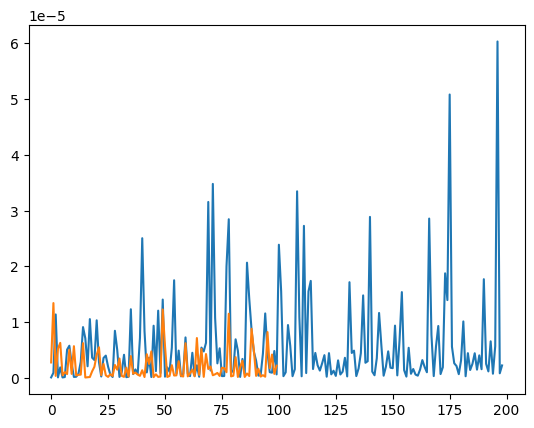

In [28]:
# Compute variance
var_diff_shape = torch.zeros_like(ref_grad_shape)
var_diff_exp = torch.zeros_like(ref_grad_exp)
for s, e in saved_values:
    var_diff_shape += torch.square(s - ref_grad_shape)
    var_diff_exp += torch.square(e - ref_grad_exp)
var_diff_shape /= len(saved_values)
var_diff_exp /= len(saved_values)
print(saved_values[0][0].shape)
plt.plot(range(saved_values[0][0].shape[1]), var_diff_shape[0].numpy())
plt.plot(range(saved_values[0][1].shape[1]), var_diff_exp[0].numpy())
plt.show()

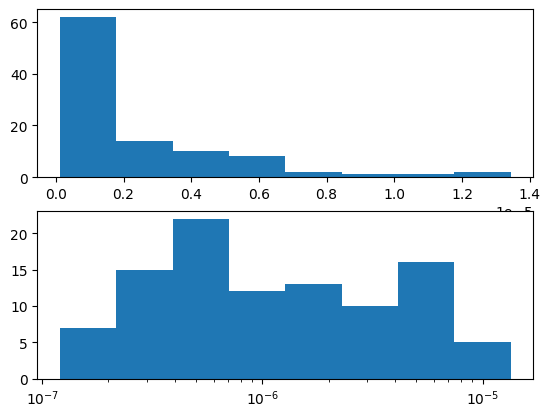

In [32]:
import numpy as np
def show_hist(x):
    # histogram on linear scale
    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=8)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

show_hist(var_diff_exp.numpy()[0])

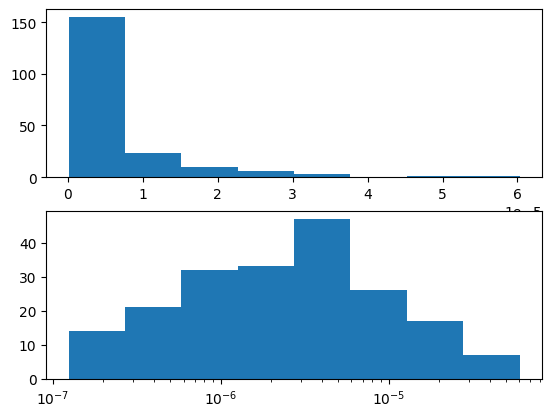

In [33]:
show_hist(var_diff_shape.numpy()[0])